In [1]:
using DifferentialEquations
using Plots
gr(fmt="png", size=(800, 300))

include("../src/HHModel.jl")

Main.HHModel

In [5]:
# stimulus protocol
current_step = (t, param) -> begin
    (param.start < t)&(t < param.dur + param.start) ? param.step + param.noise * (rand()-0.5) : param.noise * (rand()-0.5)
end

#5 (generic function with 1 method)

In [6]:
# biophysical model setup ==> usu. for maximum conductance

htk = HHModel.high_voltage_gated_potassium(2.8)
ltk = HHModel.low_voltage_gated_potassium(2.1, subtype=:kv1)
# ik = HHModel.hh_potassium()
ina = HHModel.hh_sodium(13.0)
ih = HHModel.ihcurrent(0.83)
il = HHModel.leakage(0.03)

# _model = [htk, ltk, ina, ih, il]
_model = [htk, ina, ih, il]
_model_sim = HHModel.simpleConductanceModel(_model, current_step, C=0.9)

#52 (generic function with 1 method)

  1.729777 seconds (10.29 M allocations: 1.303 GiB, 21.87% gc time)


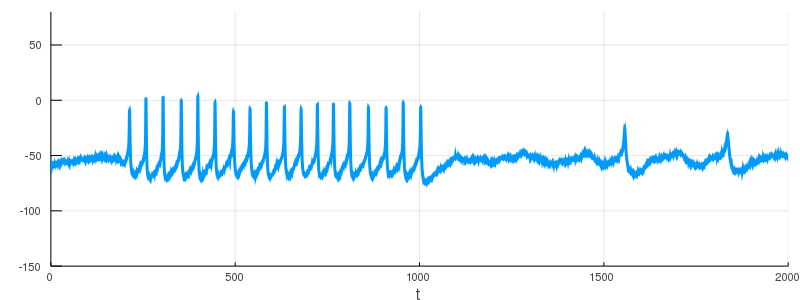

In [23]:
# running the simulation
_p = (E=(sodium=81.27, potassium=-80.78, ih=-26.0, leak=-65.0, syn=3.0), 
      stim=(start=200, step=1, dur=800, noise=0.7),)

tspan = (0.0, 2000.0)
v0 = -60.0
u0 = HHModel.setup_init(_model, v0)

prob = ODEProblem(_model_sim, u0, tspan, _p)
@time sol = solve(prob, Tsit5(), dt=0.1)

# preview voltage
plot(sol, vars=(1), legend=nothing, ylim=(-150, 80))
# savefig("demo2.svg")

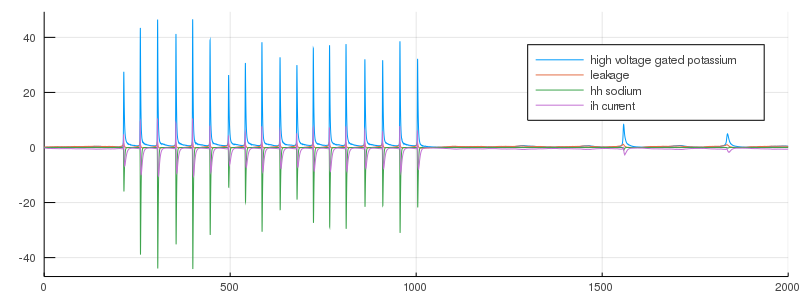

In [29]:
# preview current
_trange = 0:0.1:2000
_trace = HHModel.current_decompose(sol, _model, _trange, _p)
plot(xlim=(_trange[1], _trange[end]))
for (key, val) in _trace
    if key == "voltage"
        continue
    end
    plot!(_trange, val, label=key)
end
plot!()
# savefig("demo2_current.svg")

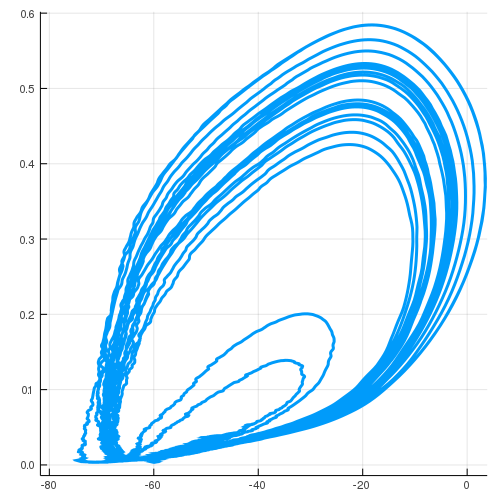

In [25]:
# preview dynamics
plot(sol, vars=(1,2), size=(500, 500), legend=nothing)

---

 18.424961 seconds (122.29 M allocations: 12.511 GiB, 16.33% gc time)


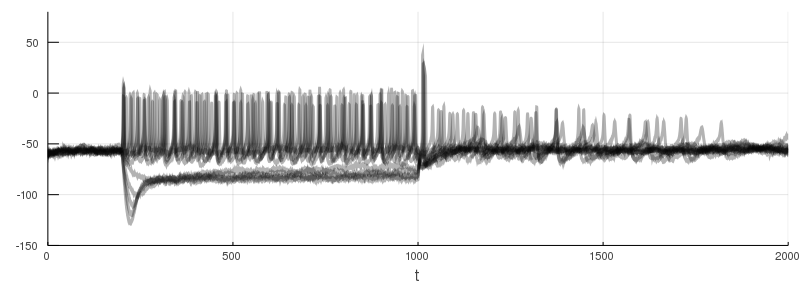

In [14]:
# sweep protocol

_current_steps = -5:1:5

plot(legend=nothing, ylim=(-150, 80), xlim=(190, 250))

@time for _i_step in _current_steps
    _p = (E=(sodium=81.27, potassium=-80.78, ih=-26, leak=-65, syn=3), 
      stim=(start=200, step=_i_step, dur=800, noise=0.5),)
    prob = ODEProblem(_model_sim, u0, tspan, _p)
    sol = solve(prob, Tsit5(), dt=0.1)

    plot!(sol, vars=(1), color=:black, alpha=0.3)
end

plot!()